**SPK PENENTUAN HARGA RUMAH DI JABODETABEK DENGAN ALGORITMA GRADIENT BOOSTING: XGBOOST**

## Import Library

In [1]:
import pandas as pd  # Mengimpor pustaka pandas untuk manipulasi dan analisis data
import matplotlib.pyplot as plt  # Mengimpor pustaka matplotlib untuk visualisasi grafik
import numpy as np  # Mengimpor pustaka numpy untuk operasi numerik
import seaborn as sns  # Mengimpor pustaka seaborn untuk visualisasi data yang lebih cantik
import xgboost as xgb  # Mengimpor pustaka xgboost untuk algoritma boosting
import joblib  # Mengimpor pustaka joblib untuk menyimpan dan memuat model
from sklearn.preprocessing import MultiLabelBinarizer  # Mengimpor kelas MultiLabelBinarizer untuk melakukan binarisasi multi-label
from sklearn.preprocessing import PowerTransformer  # Mengimpor kelas PowerTransformer untuk melakukan transformasi box-cox
from sklearn.model_selection import train_test_split  # Mengimpor fungsi train_test_split untuk membagi data menjadi data latih dan data uji
from sklearn.model_selection import GridSearchCV  # Mengimpor kelas GridSearchCV untuk mencari hyperparameter terbaik
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Mengimpor metrik evaluasi untuk mengukur kinerja model

## Load Dataset

In [2]:
# Mengimpor data
path = './data/jabodetabek_house_price.csv'
df = pd.read_csv(path)

In [3]:
df.head().T

,0,1,2,3,4
url,https://www.rumah123.com/properti/bekasi/hos11...,https://www.rumah123.com/properti/bekasi/hos10...,https://www.rumah123.com/properti/bekasi/hos10...,https://www.rumah123.com/properti/bekasi/hos10...,https://www.rumah123.com/properti/bekasi/hos10...
price_in_rp,2990000000.0,1270000000.0,1950000000.0,3300000000.0,4500000000.0
title,Rumah cantik Sumarecon Bekasi\nLingkungan asri...,"Rumah Kekinian, Magenta Summarecon Bekasi",Rumah Cantik 2 Lantai Cluster Bluebell Summare...,Rumah Mewah 2Lantai L10x18 C di Cluster VERNON...,"Rumah Hoek di Cluster Maple Summarecon Bekasi,..."
address,"Summarecon Bekasi, Bekasi","Summarecon Bekasi, Bekasi","Summarecon Bekasi, Bekasi","Summarecon Bekasi, Bekasi","Summarecon Bekasi, Bekasi"
district,Summarecon Bekasi,Summarecon Bekasi,Summarecon Bekasi,Summarecon Bekasi,Summarecon Bekasi
city,Bekasi,Bekasi,Bekasi,Bekasi,Bekasi
lat,-6.223945,-6.223945,-6.223945,-6.223945,-6.223945
long,106.986275,106.986275,106.986275,106.986275,106.986275
facilities,"Tempat Jemuran, Jalur Telepon, Taman, Taman",Taman,"Jogging Track, Kolam Renang, Masjid, Taman,...","Jalur Telepon, Jogging Track, Track Lari, K...","Jogging Track, Kolam Renang, Taman, Jalur Te..."
property_type,rumah,rumah,rumah,rumah,rumah


## Eksplorasi dan Pembersihan Data

In [4]:
# Memeriksa tipe data pada df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3553 entries, 0 to 3552
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   url                   3553 non-null   object 
 1   price_in_rp           3553 non-null   float64
 2   title                 3553 non-null   object 
 3   address               3553 non-null   object 
 4   district              3553 non-null   object 
 5   city                  3553 non-null   object 
 6   lat                   3553 non-null   float64
 7   long                  3553 non-null   float64
 8   facilities            3553 non-null   object 
 9   property_type         3552 non-null   object 
 10  ads_id                3549 non-null   object 
 11  bedrooms              3519 non-null   float64
 12  bathrooms             3524 non-null   float64
 13  land_size_m2          3551 non-null   float64
 14  building_size_m2      3551 non-null   float64
 15  carports             

### Drop dan Rename

In [5]:
# Menghapus kolom yang tidak digunakan
df.drop(columns=["url", "title", "address", "district", "lat", "long", "property_type", "ads_id", "carports", "electricity",
                 "year_built", "property_condition", "building_orientation", "garages", "furnishing"], inplace=True)

df['total_bedroom'] = df['bedrooms'] +  df['maid_bedrooms']
df['total_bathroom'] = df['bathrooms'] +  df['maid_bathrooms']

df.drop(columns=['bedrooms', 'maid_bedrooms', 'bathrooms', 'maid_bathrooms'], inplace=True)

In [6]:
# Mengganti nama kolom
new_columns = {
    'price_in_rp': 'harga',
    'city': 'lokasi',
    'facilities': 'fasilitas',
    'land_size_m2': 'luas_tanah',
    'building_size_m2': 'luas_bangunan',
    'certificate': 'sertifikat',
    'floors': 'jumlah_lantai',
    'building_age': 'umur_bangunan',
    'total_bedroom': 'jumlah_kamar_tidur',
    'total_bathroom': 'jumlah_kamar_mandi'
}

df = df.rename(columns=new_columns)

### Data Duplikat

In [7]:
# Mengidentifikasi data duplikat
df.duplicated().sum()

485

In [8]:
# Menghapus data duplikat
df = df.drop_duplicates()

### Missing Values

In [9]:
# Memeriksa missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

,0
luas_tanah,2
luas_bangunan,2
sertifikat,122
jumlah_lantai,6
umur_bangunan,1047
jumlah_kamar_tidur,33
jumlah_kamar_mandi,28


In [10]:
# Memeriksa distribusi nilai unik pada kolom `sertifikat`
print(df['sertifikat'].value_counts())

sertifikat
shm - sertifikat hak milik       2565
hgb - hak guna bangunan           190
lainnya (ppjb,girik,adat,dll)     190
hp - hak pakai                      1
Name: count, dtype: int64


In [11]:
# Mengisi nilai yang hilang pada kolom `sertifikat`
data = df.copy()
data['sertifikat'] = data['sertifikat'].fillna('lainnya (ppjb,girik,adat,dll)')

In [12]:
# Memeriksa missing values
missing_values = data.isnull().sum()
missing_values[missing_values > 0]

,0
luas_tanah,2
luas_bangunan,2
jumlah_lantai,6
umur_bangunan,1047
jumlah_kamar_tidur,33
jumlah_kamar_mandi,28


In [13]:
# Memeriksa distribusi nilai unik pada kolom `umur_bangunan`
print(data['umur_bangunan'].value_counts())

umur_bangunan
0.0      997
1.0      191
7.0      118
2.0      102
4.0       78
3.0       67
5.0       62
12.0      61
6.0       57
8.0       42
10.0      38
22.0      36
9.0       27
17.0      23
13.0      20
11.0      13
16.0      10
14.0      10
15.0       9
20.0       7
27.0       7
18.0       5
21.0       5
34.0       4
23.0       4
32.0       4
24.0       3
19.0       3
29.0       2
36.0       2
42.0       2
28.0       2
26.0       1
52.0       1
152.0      1
40.0       1
37.0       1
46.0       1
45.0       1
49.0       1
121.0      1
30.0       1
Name: count, dtype: int64


In [14]:
# Mengisi nilai yang hilang pada kolom `umur_bangunan`
data['umur_bangunan'] = data['umur_bangunan'].fillna(0.0)

In [15]:
# Memeriksa missing values
missing_values = data.isnull().sum()
missing_values[missing_values > 0]

,0
luas_tanah,2
luas_bangunan,2
jumlah_lantai,6
jumlah_kamar_tidur,33
jumlah_kamar_mandi,28


In [16]:
# Menghapus baris yang mengandung missing value
datax = data.dropna()

In [17]:
# Memeriksa missing values
missing_values = datax.isnull().sum()
missing_values[missing_values > 0]

,0


### Format Data Type

In [18]:
datax.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3026 entries, 0 to 3549
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   harga               3026 non-null   float64
 1   lokasi              3026 non-null   object 
 2   fasilitas           3026 non-null   object 
 3   luas_tanah          3026 non-null   float64
 4   luas_bangunan       3026 non-null   float64
 5   sertifikat          3026 non-null   object 
 6   jumlah_lantai       3026 non-null   float64
 7   umur_bangunan       3026 non-null   float64
 8   jumlah_kamar_tidur  3026 non-null   float64
 9   jumlah_kamar_mandi  3026 non-null   float64
dtypes: float64(7), object(3)
memory usage: 260.0+ KB


In [19]:
df_format = datax.copy()

# Merubah format data kolom tertentu menjadi int16
int_cols = ['jumlah_lantai', 'umur_bangunan', 'jumlah_kamar_tidur', 'jumlah_kamar_mandi']
for col in int_cols:
  df_format[col] = df_format[col].astype('int16')

# Merubah format data kolom tertentu menjadi float32
float_cols = ['harga', 'luas_tanah', 'luas_bangunan']
for col in float_cols:
  df_format[col] = df_format[col].astype('float32')

In [20]:
df_format.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3026 entries, 0 to 3549
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   harga               3026 non-null   float32
 1   lokasi              3026 non-null   object 
 2   fasilitas           3026 non-null   object 
 3   luas_tanah          3026 non-null   float32
 4   luas_bangunan       3026 non-null   float32
 5   sertifikat          3026 non-null   object 
 6   jumlah_lantai       3026 non-null   int16  
 7   umur_bangunan       3026 non-null   int16  
 8   jumlah_kamar_tidur  3026 non-null   int16  
 9   jumlah_kamar_mandi  3026 non-null   int16  
dtypes: float32(3), int16(4), object(3)
memory usage: 153.7+ KB


### Encoding Kolom Kategorikal

In [21]:
# Memeriksa nilai unik pada kolom `lokasi`
print(df_format['lokasi'].value_counts())

lokasi
Tangerang          726
Bogor              720
Bekasi             523
Depok              387
Jakarta Selatan    233
Jakarta Barat      193
Jakarta Utara      122
Jakarta Timur       86
Jakarta Pusat       36
Name: count, dtype: int64


In [22]:
# Memeriksa nilai unik pada kolom `sertifikat`
print(df_format['sertifikat'].value_counts())

sertifikat
shm - sertifikat hak milik       2530
lainnya (ppjb,girik,adat,dll)     305
hgb - hak guna bangunan           190
hp - hak pakai                      1
Name: count, dtype: int64


In [23]:
# Melakukan one-hot encoding pada kolom `sertifikat` dan `lokasi`
df_encoded = pd.get_dummies(df_format, columns=['sertifikat', 'lokasi'], prefix=['sertifikat', 'lokasi'], drop_first=False, dtype='int8')

In [24]:
df_encoded.head().T

,0,1,2,3,4
harga,2990000128.0,1270000000.0,1950000000.0,3300000000.0,4499999744.0
fasilitas,"Tempat Jemuran, Jalur Telepon, Taman, Taman",Taman,"Jogging Track, Kolam Renang, Masjid, Taman,...","Jalur Telepon, Jogging Track, Track Lari, K...","Jogging Track, Kolam Renang, Taman, Jalur Te..."
luas_tanah,239.0,55.0,119.0,180.0,328.0
luas_bangunan,272.0,69.0,131.0,174.0,196.0
jumlah_lantai,2,2,2,2,2
umur_bangunan,5,0,0,6,9
jumlah_kamar_tidur,4,3,4,4,5
jumlah_kamar_mandi,5,2,4,4,4
sertifikat_hgb - hak guna bangunan,0,1,1,0,0
sertifikat_hp - hak pakai,0,0,0,0,0


In [25]:
# Mengganti nama kolom `lokasi`
lokasi_cols = [col for col in df_encoded.columns if col.startswith('lokasi_')]
lokasi_names = [col.replace('lokasi_ ', '').replace(' ', '_').lower() for col in lokasi_cols]
df_encoded.rename(columns=dict(zip(lokasi_cols, lokasi_names)), inplace=True)

# Menghapus kolom `sertifikat_hp`
df_encoded.drop(columns=['sertifikat_hp - hak pakai'], inplace=True)

# Mengganti nama kolom `sertifikat`
new_columns = {
    'sertifikat_hgb - hak guna bangunan': 'sertifikat_hgb',
    'sertifikat_lainnya (ppjb,girik,adat,dll)': 'sertifikat_lainnya',
    'sertifikat_shm - sertifikat hak milik': 'sertifikat_shm',
}
df_encoded = df_encoded.rename(columns=new_columns)

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3026 entries, 0 to 3549
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   harga               3026 non-null   float32
 1   fasilitas           3026 non-null   object 
 2   luas_tanah          3026 non-null   float32
 3   luas_bangunan       3026 non-null   float32
 4   jumlah_lantai       3026 non-null   int16  
 5   umur_bangunan       3026 non-null   int16  
 6   jumlah_kamar_tidur  3026 non-null   int16  
 7   jumlah_kamar_mandi  3026 non-null   int16  
 8   sertifikat_hgb      3026 non-null   int8   
 9   sertifikat_lainnya  3026 non-null   int8   
 10  sertifikat_shm      3026 non-null   int8   
 11  bekasi              3026 non-null   int8   
 12  bogor               3026 non-null   int8   
 13  depok               3026 non-null   int8   
 14  jakarta_barat       3026 non-null   int8   
 15  jakarta_pusat       3026 non-null   int8   
 16  jakarta_sel

### Split dan Encoding Kolom `fasilitas`

In [26]:
# Memeriksa nilai unik pada kolom `fasilitas`
df_encoded['fasilitas'].value_counts()

,count
fasilitas,
"Keamanan, Taman",158
"Taman, Keamanan",71
Keamanan 24 jam,50
Taman,45
Jalur Telepon,34
...,...
"Ac, Jogging Track, Track Lari, Masjid, Keamanan 24 jam, Taman, Taman, AC, Keamanan",1
"Jalur Telepon, Masjid, CCTV, Wastafel, AC, Jalur Telepon, Tempat Jemuran, Lapangan Bola, Akses Parkir, One Gate System, Keamanan 24 jam, Taman, Tempat Laundry, Ac, Playground, Masjid, Keamanan, Lapangan Basket, Jogging Track, Track Lari",1
"Tempat Jemuran, Lapangan Bola, Taman, Wastafel, Masjid, CCTV, Jalur Telepon, Keamanan, Lapangan Basket",1


In [27]:
df_fl = df_encoded.copy()

# Membuat kolom baru yang berisi nilai dari kolom fasilitas yang sudah di-split
df_fl['fasilitas'] = df_fl['fasilitas'].str.lower()
df_fl['fasilitas_list'] = df_fl['fasilitas'].str.split(', ')

In [28]:
# Daftar target fasilitas yang akan di-encode (label untuk binarisasi multi-label)
target_fasilitas = ['kolam renang', 'jogging track', 'taman', 'tempat jemuran', 'track lari', 'masjid', 'jalur telepon']

# Inisialisasi MultiLabelBinarizer dengan daftar target fasilitas
mlb = MultiLabelBinarizer(classes=target_fasilitas)

In [29]:
# Melakukan transformasi multi-label binarization pada kolom 'fasilitas_list'
encoded_fasilitas = mlb.fit_transform(df_fl['fasilitas_list'])

# Membuat DataFrame baru dari hasil encoding untuk menyimpan kolom baru sesuai target
encoded_df = pd.DataFrame(encoded_fasilitas, columns=mlb.classes_, index=df_fl.index, dtype='int8')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['', ' 1 unit ac', ' ac', ' ac 3 unit', ' akses parkir', ' balkon', ' basement', ' canopy', ' carport', ' carport 1 mobil', ' carport 2 mobil', ' cctv', ' clubhouse', ' dapur bersih dan kotor', ' free kitchen set', ' garasi', ' jalur telepon', ' jetpump', ' jogging track', ' keamanan', ' kitchen set', ' kolam ikan', ' kolam renang', ' kolam renang anak', ' kompor', ' kompor exhaust', ' lapangan basket', ' lapangan bulu tangkis', ' lapangan voli', ' living room', ' masjid', ' mesin cuci', ' mushola', ' musholla exclusive', ' one gate sistem', ' one gate system', ' pemanas air', ' playground', ' pompa air wasser dan booster', ' posisi hoek', ' security 24 jam', ' service area', ' smarthome', ' swimming pool', ' taman', ' taman luas', ' tempat gym', ' tempat laundry', ' torn 650ltr', ' track lari', ' void', ' water heater', '2 unit ac', 'ac', 'ac 2 unit', 'akses parkir', 'backyard l

In [30]:
# Menggabungkan df_fl dengan encoded_df
df_fl = pd.concat([df_fl, encoded_df], axis=1)
df_last = df_fl.drop(columns=['fasilitas', 'fasilitas_list'])

In [31]:
df_last.head().T

,0,1,2,3,4
harga,2.990000e+09,1.270000e+09,1.950000e+09,3.300000e+09,4.500000e+09
luas_tanah,2.390000e+02,5.500000e+01,1.190000e+02,1.800000e+02,3.280000e+02
luas_bangunan,2.720000e+02,6.900000e+01,1.310000e+02,1.740000e+02,1.960000e+02
jumlah_lantai,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
umur_bangunan,5.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,9.000000e+00
jumlah_kamar_tidur,4.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00
jumlah_kamar_mandi,5.000000e+00,2.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
sertifikat_hgb,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
sertifikat_lainnya,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
sertifikat_shm,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


In [32]:
# Mengganti nama kolom fasilitas
new_columns = {
    'kolam renang': 'kolam_renang',
    'jogging track': 'jogging_track',
    'tempat jemuran': 'tempat_jemuran',
    'track lari': 'track_lari',
    'jalur telepon': 'jalur_telepon'
}
df_last = df_last.rename(columns=new_columns)

df_last.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3026 entries, 0 to 3549
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   harga               3026 non-null   float32
 1   luas_tanah          3026 non-null   float32
 2   luas_bangunan       3026 non-null   float32
 3   jumlah_lantai       3026 non-null   int16  
 4   umur_bangunan       3026 non-null   int16  
 5   jumlah_kamar_tidur  3026 non-null   int16  
 6   jumlah_kamar_mandi  3026 non-null   int16  
 7   sertifikat_hgb      3026 non-null   int8   
 8   sertifikat_lainnya  3026 non-null   int8   
 9   sertifikat_shm      3026 non-null   int8   
 10  bekasi              3026 non-null   int8   
 11  bogor               3026 non-null   int8   
 12  depok               3026 non-null   int8   
 13  jakarta_barat       3026 non-null   int8   
 14  jakarta_pusat       3026 non-null   int8   
 15  jakarta_selatan     3026 non-null   int8   
 16  jakarta_tim

### Eksplorasi Data

In [33]:
df_last.describe()

,harga,luas_tanah,luas_bangunan,jumlah_lantai,umur_bangunan,jumlah_kamar_tidur,jumlah_kamar_mandi,sertifikat_hgb,sertifikat_lainnya,sertifikat_shm,...,jakarta_timur,jakarta_utara,tangerang,kolam_renang,jogging_track,taman,tempat_jemuran,track_lari,masjid,jalur_telepon
count,3.026000e+03,3026.000000,3026.000000,3026.000000,3026.000000,3026.000000,3026.000000,3026.000000,3026.000000,3026.000000,...,3026.000000,3026.000000,3026.000000,3026.000000,3026.000000,3026.000000,3026.000000,3026.000000,3026.000000,3026.000000
mean,4.579699e+09,215.103760,197.471252,1.797422,2.600132,3.913417,3.122274,0.062789,0.100793,0.836087,...,0.028420,0.040317,0.239921,0.121943,0.107072,0.607403,0.304693,0.244217,0.215796,0.334104
std,1.480953e+10,421.124207,262.749420,0.643549,6.544903,3.062615,3.051880,0.242623,0.301104,0.370258,...,0.166198,0.196735,0.427105,0.327274,0.309256,0.488409,0.460353,0.429693,0.411442,0.471754
min,4.200000e+07,12.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000e+08,72.000000,66.000000,1.000000,0.000000,3.000000,2.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.620000e+09,112.000000,120.000000,2.000000,0.000000,4.000000,3.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,3.980000e+09,200.000000,231.750000,2.000000,2.000000,5.000000,4.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,5.800000e+11,8000.000000,6000.000000,5.000000,152.000000,99.000000,99.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


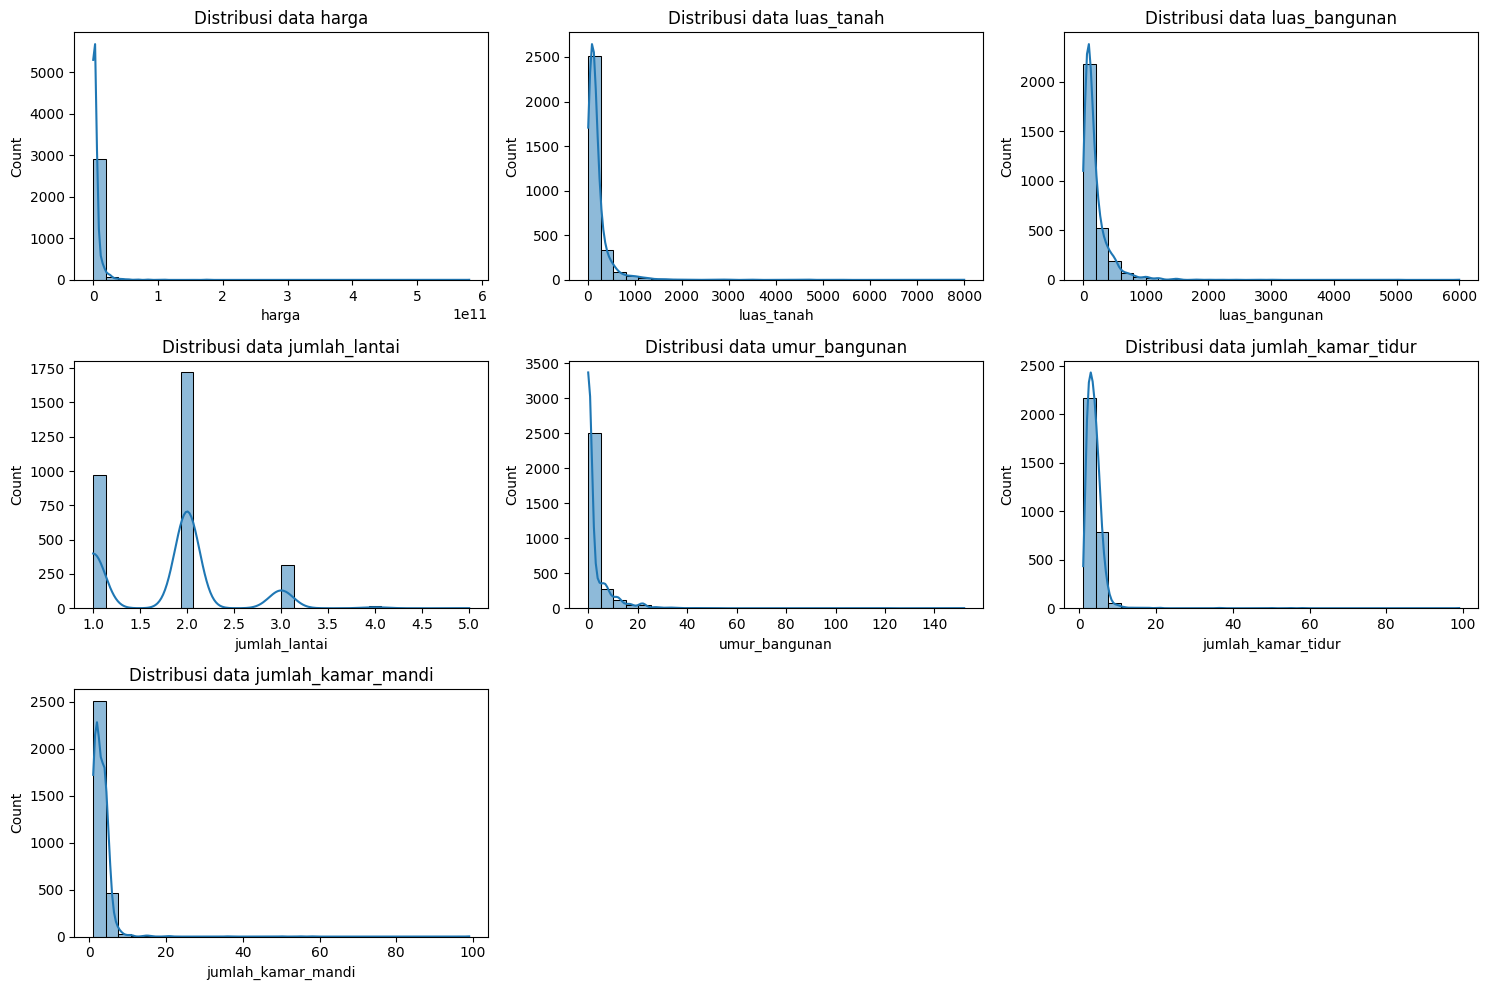

In [34]:
# Histogram Distribusi Data Numerik
numerical_features = df_last.select_dtypes(include=['float32', 'int16']).columns

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_last[feature], kde=True, bins=30)
    plt.title(f"Distribusi data {feature}")
plt.tight_layout()
plt.show()

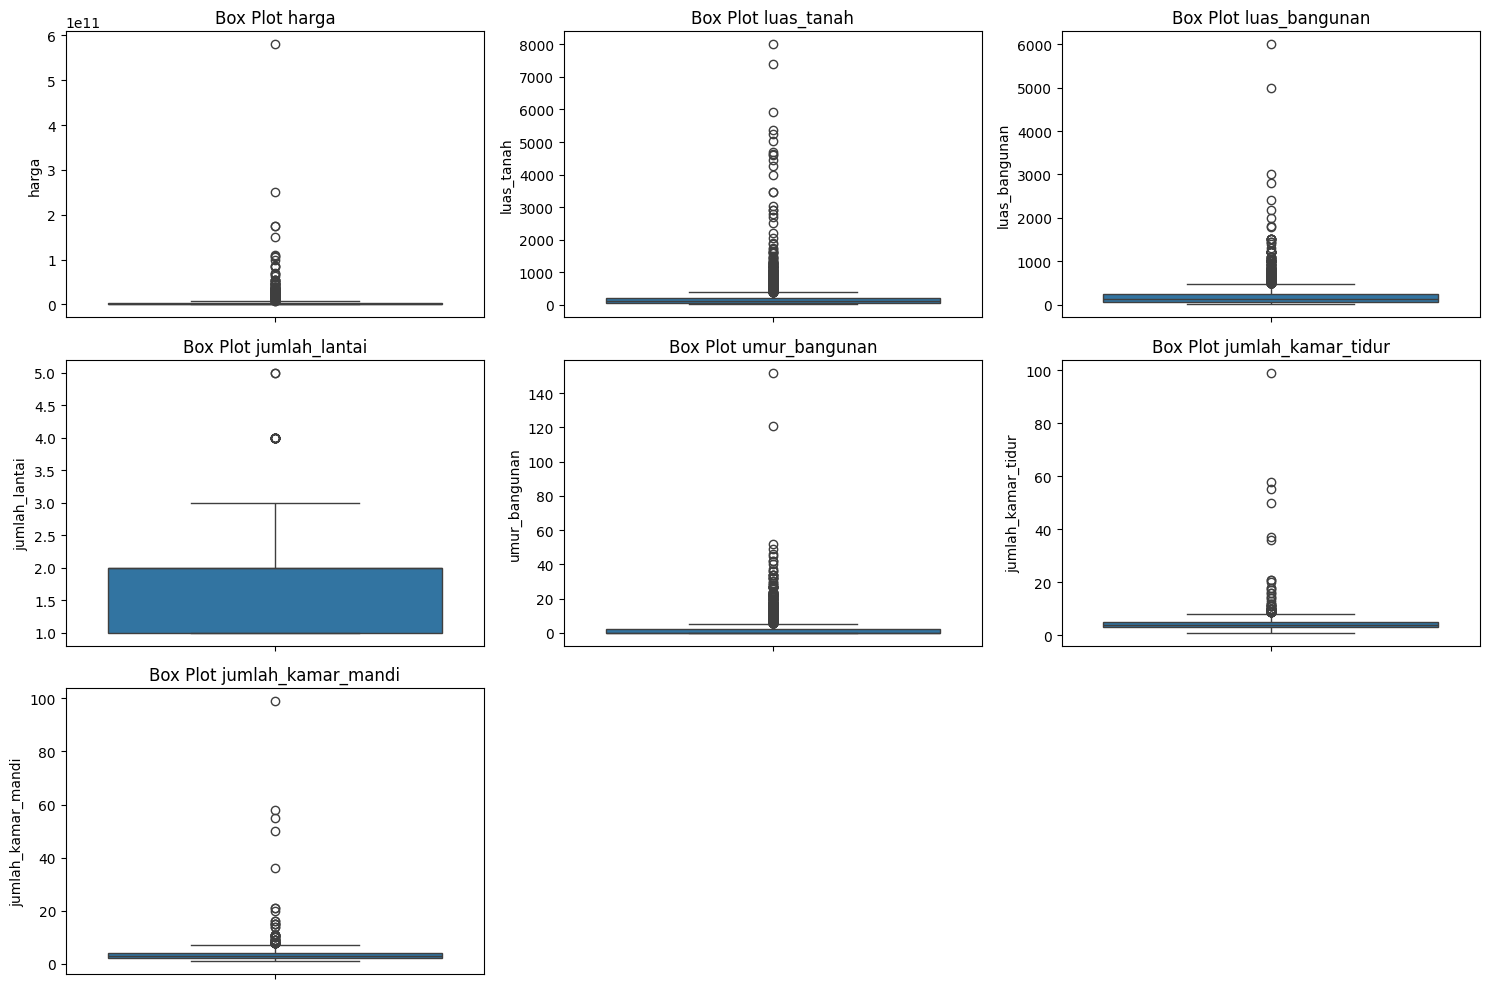

In [35]:
# Box Plot Outlier
plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df_last[feature])
    plt.title(f'Box Plot {feature}')
plt.tight_layout()
plt.show()

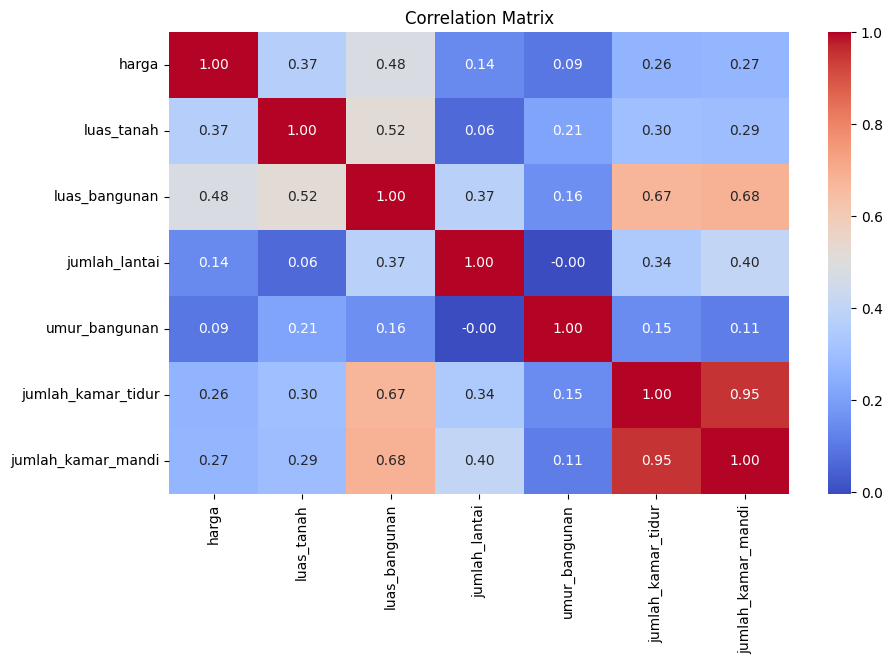

In [36]:
# Heatmap Korelasi Antar Fitur
numerical_df = df_last.select_dtypes(include=['float32', 'int16'])

plt.figure(figsize=(10, 6))
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

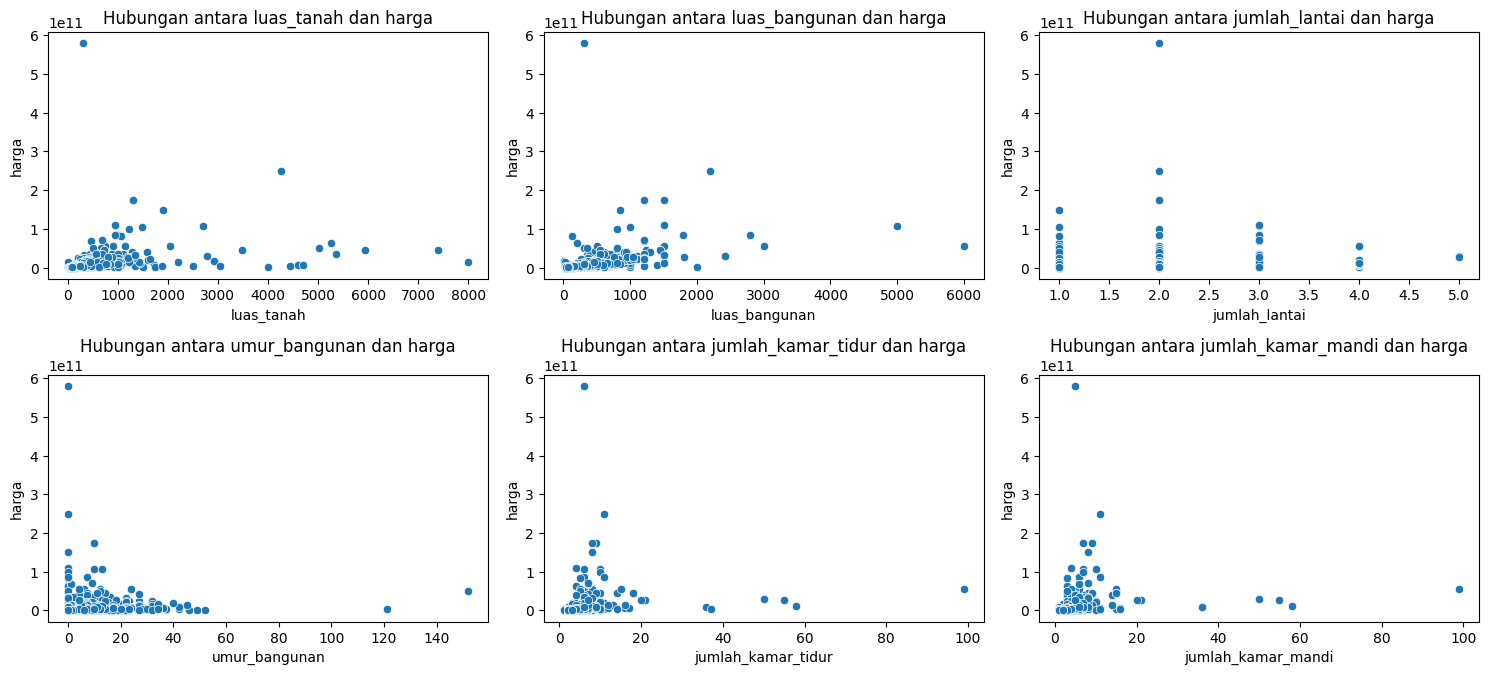

In [37]:
# Scatter Plot Hubungan Antara Target dengan Fitur-Fitur
target = 'harga'

plt.figure(figsize=(15, 10))
count = 1
for feature in numerical_features:
    if feature != target:
        plt.subplot(3, 3, count)
        sns.scatterplot(x=df_last[feature], y=df_last[target])
        plt.title(f"Hubungan antara {feature} dan {target}")
        count += 1
plt.tight_layout()
plt.show()

### Transformasi Box Cox

**Dilakukan transformasi untuk menyamaratakan distribusi data**

In [38]:
df_last.head().T

,0,1,2,3,4
harga,2.990000e+09,1.270000e+09,1.950000e+09,3.300000e+09,4.500000e+09
luas_tanah,2.390000e+02,5.500000e+01,1.190000e+02,1.800000e+02,3.280000e+02
luas_bangunan,2.720000e+02,6.900000e+01,1.310000e+02,1.740000e+02,1.960000e+02
jumlah_lantai,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
umur_bangunan,5.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,9.000000e+00
jumlah_kamar_tidur,4.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00
jumlah_kamar_mandi,5.000000e+00,2.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
sertifikat_hgb,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
sertifikat_lainnya,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
sertifikat_shm,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


In [39]:
# Menggunakan transformasi box-cox distribusi data menjadi lebih simetris (mendekati normal) dan mengurangi skewness
df_transform = df_last.copy()

# Membuat objek PowerTransformer untuk melakukan transformasi Box-Cox dan tanpa standardisasi
pt = PowerTransformer(method='box-cox', standardize=False)
df_transform[['harga', 'luas_tanah', 'luas_bangunan']] = pt.fit_transform(df_transform[['harga', 'luas_tanah', 'luas_bangunan']].replace(0, 0.000001))
df_transform.head().T

,0,1,2,3,4
harga,6.212914,6.182160,6.198074,6.216202,6.226214
luas_tanah,2.388993,2.119941,2.278866,2.347529,2.430548
luas_bangunan,3.689927,3.068259,3.375949,3.502350,3.553668
jumlah_lantai,2.000000,2.000000,2.000000,2.000000,2.000000
umur_bangunan,5.000000,0.000000,0.000000,6.000000,9.000000
jumlah_kamar_tidur,4.000000,3.000000,4.000000,4.000000,5.000000
jumlah_kamar_mandi,5.000000,2.000000,4.000000,4.000000,4.000000
sertifikat_hgb,0.000000,1.000000,1.000000,0.000000,0.000000
sertifikat_lainnya,0.000000,0.000000,0.000000,0.000000,0.000000
sertifikat_shm,1.000000,0.000000,0.000000,1.000000,1.000000


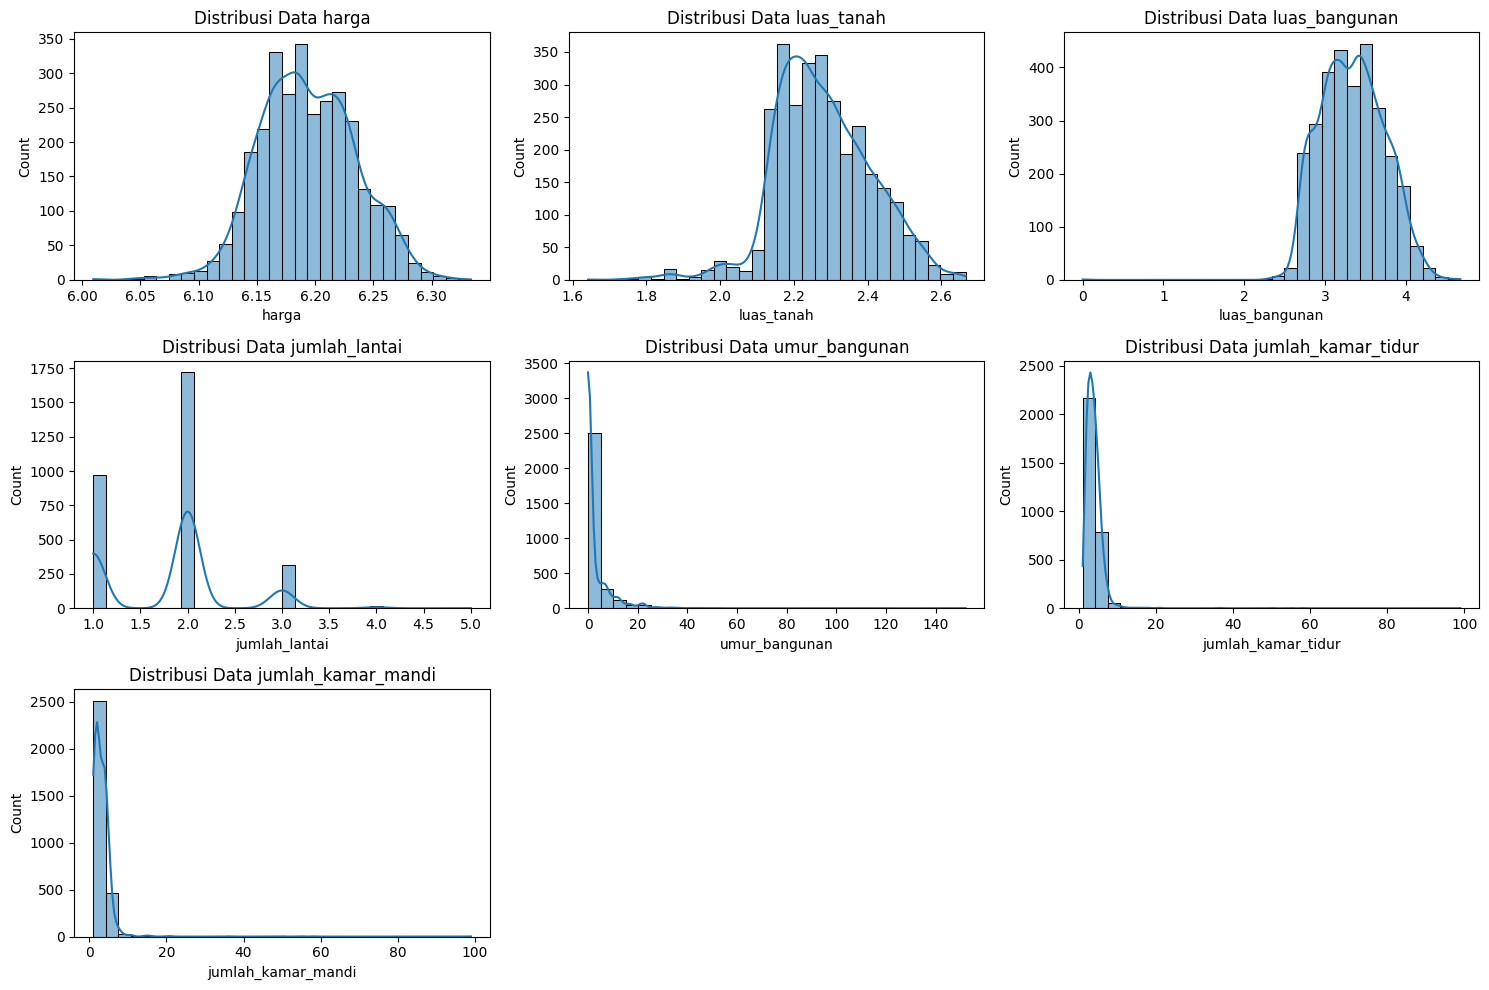

In [40]:
# Histogram Distribusi Data Numerik Setelah Transformasi
numerical_features = df_transform.select_dtypes(include=['float32', 'int16']).columns

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_transform[feature], kde=True, bins=30)
    plt.title(f"Distribusi Data {feature}")
plt.tight_layout()
plt.show()

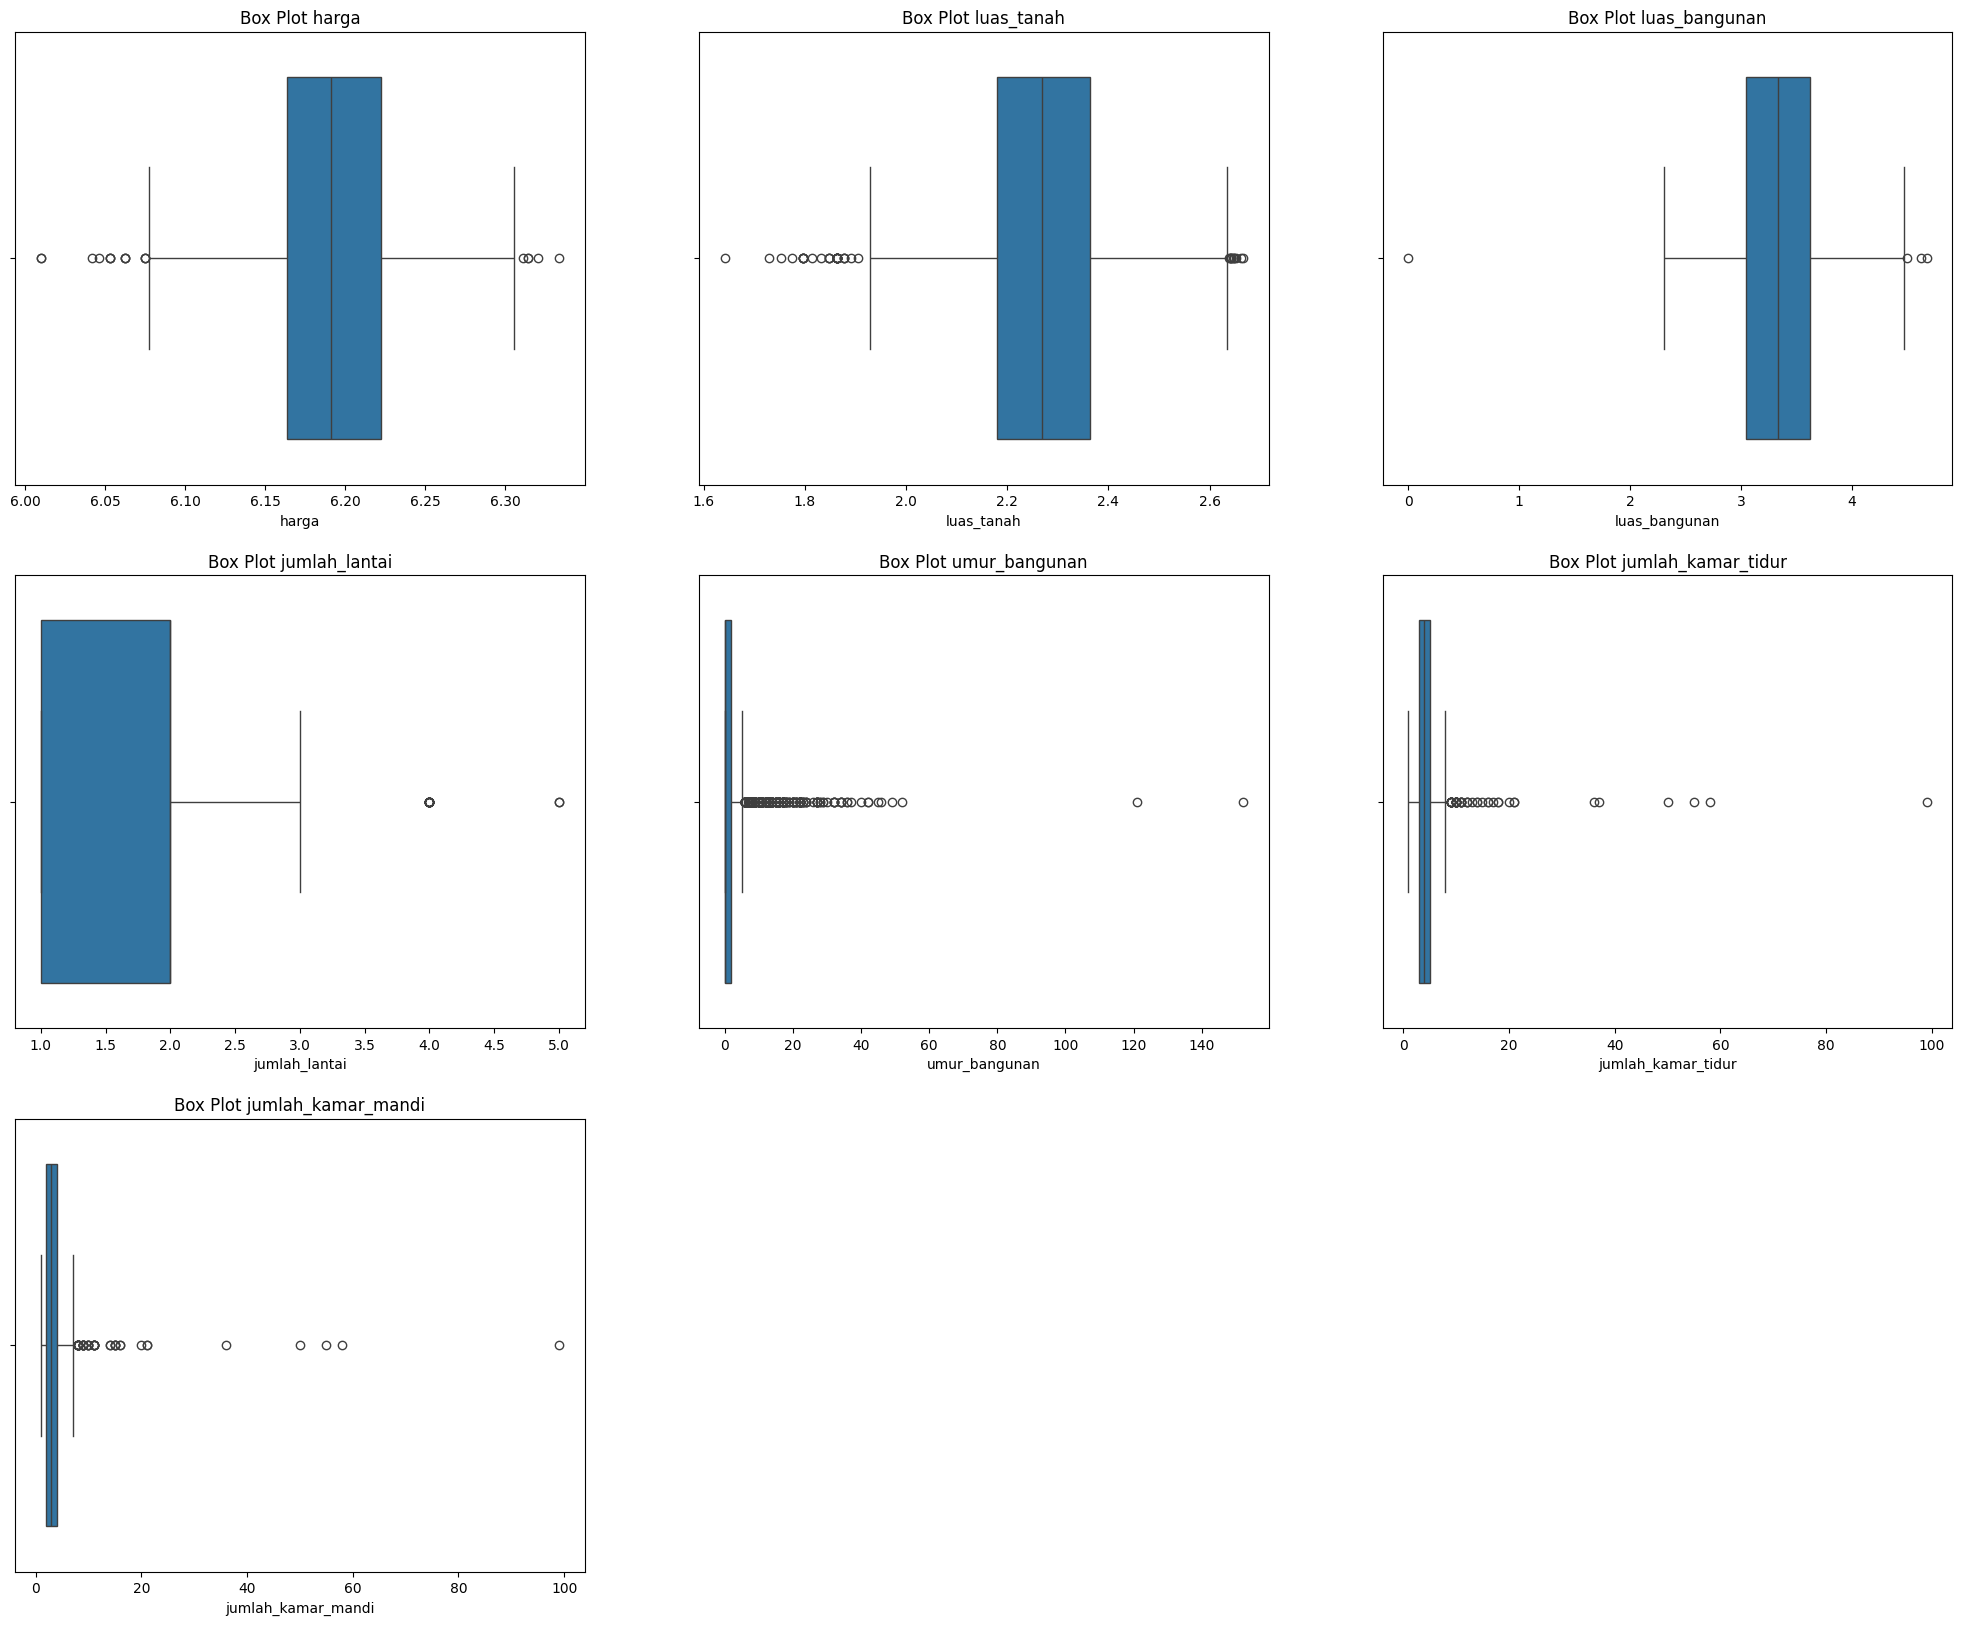

In [41]:
# Box Plot Outlier Setelah Transformasi
fig, axes = plt.subplots(3, 3, figsize=(25, 20))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(x=df_transform[feature], ax=axes[i])
    axes[i].set_title(f"Box Plot {feature}")

for j in range(i+1,len(axes)):
    fig.delaxes(axes[j])

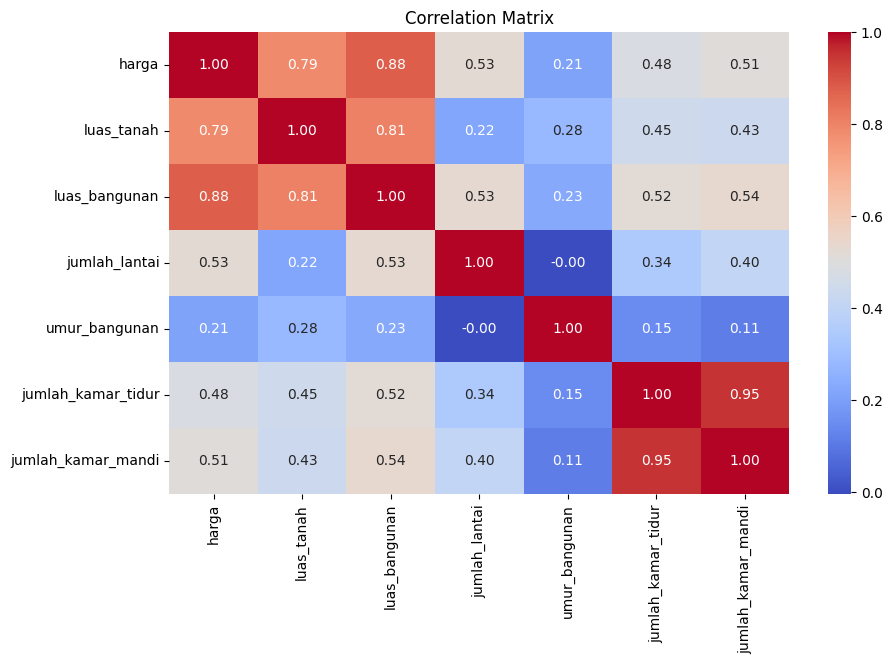

In [42]:
# Heatmap Korelasi Antar Fitur Setelah Transformasi
numerical_df = df_transform.select_dtypes(include=['float32', 'int16'])

plt.figure(figsize=(10, 6))
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

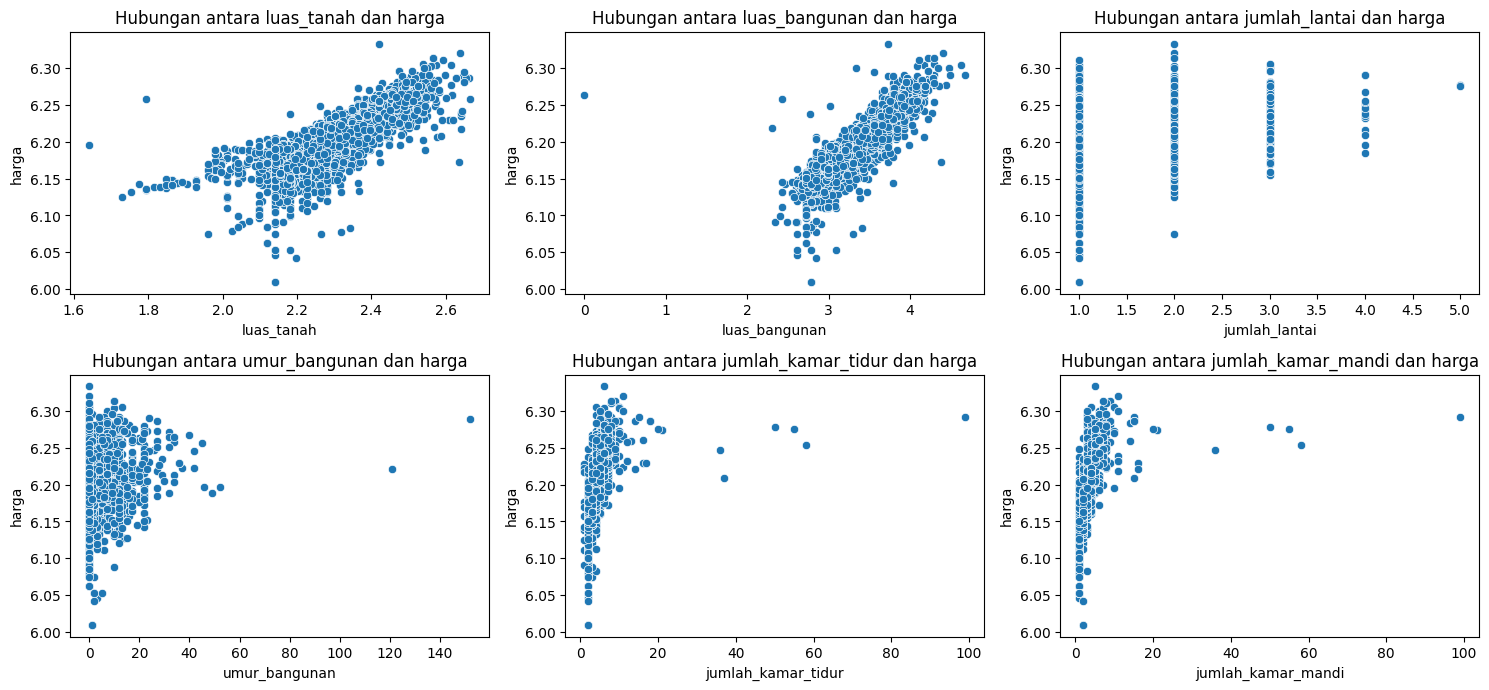

In [43]:
# Scatter Plot Hubungan Antara Target dengan Fitur-Fitur Setelah Transformasi
target = 'harga'

plt.figure(figsize=(15, 10))
count = 1
for feature in numerical_features:
    if feature != target:
        plt.subplot(3, 3, count)
        sns.scatterplot(x=df_transform[feature], y=df_transform[target])
        plt.title(f"Hubungan antara {feature} dan {target}")
        count += 1
plt.tight_layout()
plt.show()

## Modelling

In [44]:
data_train = df_transform.copy()

In [45]:
X = data_train.drop(columns='harga')
y = data_train['harga']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
'''
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300], # Berapa banyak pohon yang dicoba
    'learning_rate': [0.01, 0.05, 0.1], # Kecepatan belajar yang dicoba
    'max_depth': [3, 5, 7], # Kedalaman pohon yang dicoba
    'subsample': [0.7, 0.8, 0.9], # Proporsi sampel yang digunakan untuk setiap pohon
    'colsample_bytree': [0.7, 0.8, 0.9], # Proporsi fitur yang digunakan untuk setiap pohon
    'reg_alpha': [0, 0.1, 0.5], # Regularisasi L1
    'reg_lambda': [1, 1.5, 2] # Regularisasi L2
}

# Membuat model XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Menggunakan GridSearchCV untuk mencari hyperparameter terbaik
grid_search = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='neg_mean_squared_error', # Skor yang dimaksimalkan (negasi MSE)
                            cv=3,  # Gunakan 3-fold cross-validation
                            verbose=2, # Tingkat informasi keluaran
                            n_jobs=-1)

# Melakukan grid search pada data latih
grid_search.fit(X_train, y_train)

print("Parameter Terbaik:", grid_search.best_params_)
print("Skor Terbaik (negasi MSE):", grid_search.best_score_)

Output:
Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Parameter Terbaik: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 0.7}
Skor Terbaik (negasi MSE): -0.00017432135549218705
'''

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Parameter Terbaik: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 0.7}
Skor Terbaik (negasi MSE): -0.00017432135549218705


"\nOutput:\nFitting 3 folds for each of 2187 candidates, totalling 6561 fits\nParameter Terbaik: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 0.7}\nSkor Terbaik (negasi MSE): -0.00017432135549218705\n"

In [47]:
'''
# Melakukan prediksi pada data uji menggunakan model terbaik
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Menyimpan transformasi dan model
joblib.dump(pt, 'transform/transform.pkl'), joblib.dump(best_model, 'model/xgboost_model.pkl')
'''

(['transform/transform.pkl'], ['model/xgboost_model.pkl'])

In [ ]:
# Melakukan training dan prediksi menggunakan model yang sudah disimpan sebelumnya
model = joblib.load('model/xgboost_model.pkl')
y_pred = model.predict(X_test)

## Evaluasi Model

In [48]:
mae = mean_absolute_error(y_test, y_pred) # Rata-rata perbedaan absolut antara nilai aktual dan prediksi
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(y_test, y_pred) # Rata-rata perbedaan kuadrat antara nilai aktual dan prediksi
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, y_pred) # Persentase varian dependen yang dapat dijelaskan oleh variabel independen
print(f'R-squared: {r2}')

rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Persentase varian dependen yang dapat dijelaskan oleh variabel independen
print(f'Root Mean Squared Error:', rmse)

Mean Absolute Error: 0.009654626250267029
Mean Squared Error: 0.00021902169100940228
R-squared: 0.8739628582238128
Root Mean Squared Error: 0.014799382


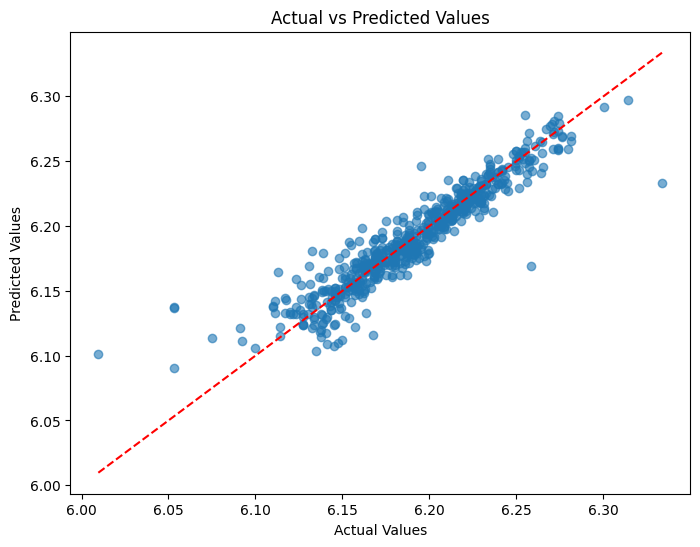

In [49]:
# Scatter plot nilai prediksi vs aktual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

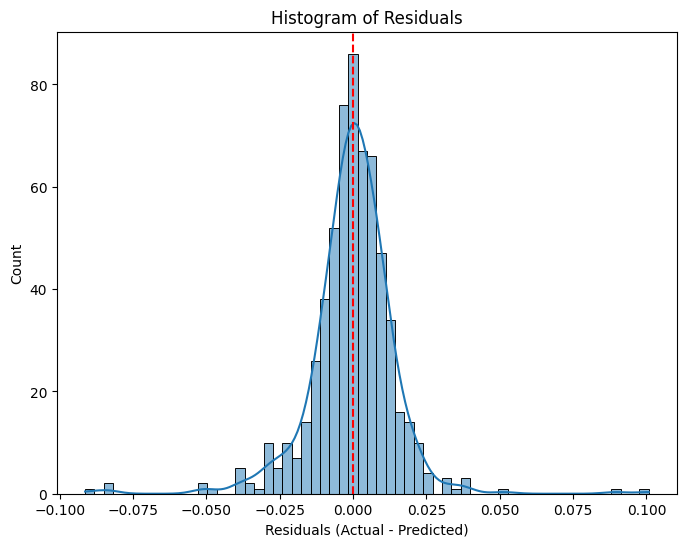

In [50]:
# Histogram Residual
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Histogram of Residuals")
plt.show()

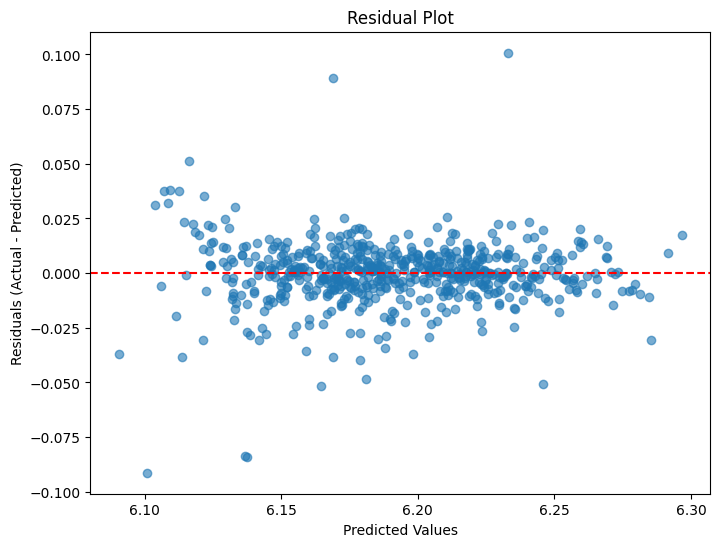

In [51]:
# Residual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()